 master-thesisInput:
- True Observations
- Number Training Steps

Output:
- New Model Parameter

Parts of Optimization:
- Initialization of Model Parameter
- tbd

# Initialization

## Import Libraries and Mount Drive

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
from torch import distributions, optim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GitHub/master-thesis

import sys
sys.path.append('/content/gdrive/My Drive/GitHub/master-thesis')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GitHub/master-thesis


In [ ]:
#%cd ..

/home/anuar/PycharmProjects/master-thesis


In [ ]:
from model.methods import *
from model.modelcore import epid_model
from model.modelhelper import *

## Optimization Settings

In [ ]:
observation = 'hospitalization' #'newly_infected' #'hospitalization'
rolling_avg_obs = 2
# Overall Time Period
start_time='2020-07-31' # Mitte November/ Anfang Dezember bis Februar
end_time='2021-02-01' # Begin Vaccination Wave


train_test_split_time='2020-12-01'


dtype = torch.float32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #cuda:0

## Initialize Observations

In [ ]:
df_obs_initial = pd.read_csv('data/220309_observations.csv' , sep=';', thousands='.', decimal=',', encoding='utf-8', parse_dates=['Date'])

# Initialize Observations Training
df_obs_train, initial_newly_infected = initialize_observations(df_obs_initial, start=start_time, end=train_test_split_time, rolling_avg=rolling_avg_obs)
observed_train = torch.tensor(df_obs_train[observation], requires_grad=False, device=device, dtype=dtype)

# Initialize Observations Testing
df_obs_test, _ = initialize_observations(df_obs_initial, start=train_test_split_time, end=end_time, rolling_avg=rolling_avg_obs)
observed_test = torch.tensor(df_obs_test[observation], requires_grad=False, device=device, dtype=dtype)

# Create df_obs
observed_train_test = torch.concat((observed_train, observed_test))
df_obs = pd.concat([df_obs_train, df_obs_test])
df_obs = df_obs.reset_index(drop=True)
df_obs.head(3)

,Date,number_of_deaths,newly_infected,hospitalization
0,2020-07-31,0.5,71.0,4.0
1,2020-08-01,0.5,61.0,3.5
2,2020-08-02,0.0,71.0,3.0


In [ ]:
#for column in df_obs.columns:
#  plt.plot(df_obs['Date'], df_obs[column])
#  plt.title(column)
#  plt.show()

## Initialize Model Parameter

### Initialize helper parameter

In [ ]:
cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)

### Initialize method parameter

In [ ]:
method = TwoClusterNN(device=device, dtype=dtype)

### Initialize alpha and phi

In [ ]:
dict_param = initialize_parameter(['alpha', 'phi'], device, dtype)
dict_param

{'prime_values': {'alpha': tensor(0.0102, requires_grad=True),
  'phi': tensor(-0., requires_grad=True)},
 'real_values': {'alpha': tensor(0.0280, grad_fn=<AddBackward0>),
  'phi': tensor(25., grad_fn=<AddBackward0>)}}

## Load Method Input Data

In [ ]:
method.set_cluster_train(start_time, train_test_split_time)
method.set_cluster_test(train_test_split_time, end_time)
cluster_percentage_train_test = np.concatenate((method.cluster_percentage_train, method.cluster_percentage_test), axis=None)

In [ ]:
method.cluster_percentage_test.shape

(62,)

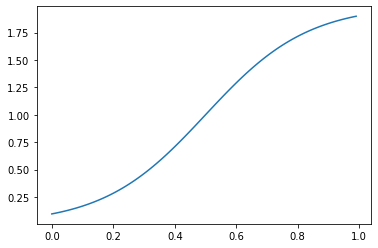

In [ ]:
list_y = []
x_ = np.arange(0,1,0.01)
for n in x_:
  x = torch.tensor(n)
  y = torch.tanh(x*3-1.5) + 1
  list_y.append(y)
plt.plot(x_, list_y)

# Optimization

## Training

Step: 0, Learning Rate: 0.00999 Time: 0.0448, Training Comparison Loss: 15427.4365234375, Test Comparison Loss: 12312.724609375, Phi: 25.0 


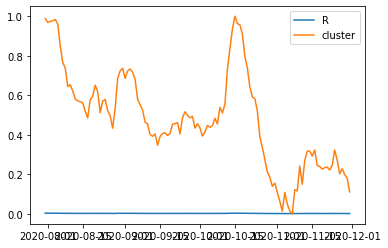

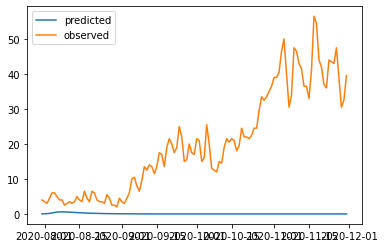

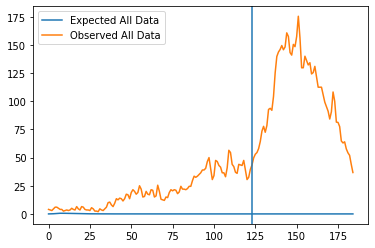

Step: 50, Learning Rate: 0.00950254422568834 Time: 0.0496, Training Comparison Loss: 15344.8466796875, Test Comparison Loss: 12312.724609375, Phi: 24.878015518188477 


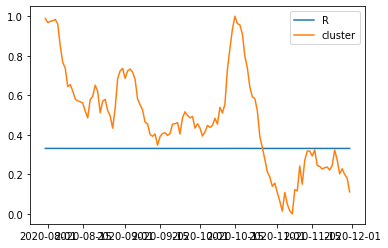

Step: 100, Learning Rate: 0.009038873549665948 Time: 0.0477, Training Comparison Loss: 2717.777099609375, Test Comparison Loss: 13975.0341796875, Phi: 24.803712844848633 


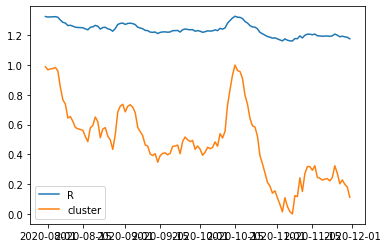

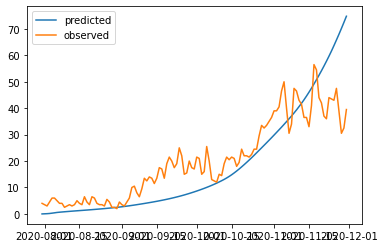

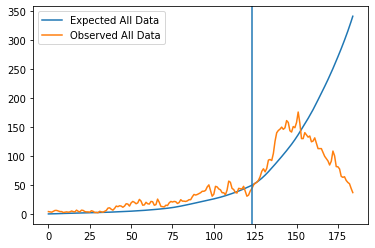

Step: 150, Learning Rate: 0.008597827393003531 Time: 0.0789, Training Comparison Loss: 1903.3072509765625, Test Comparison Loss: 21645.24609375, Phi: 24.789915084838867 


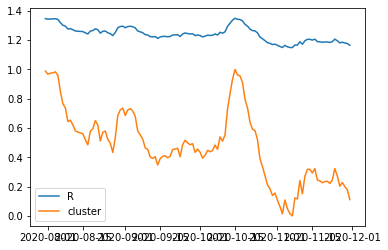

Step: 200, Learning Rate: 0.008178301806491574 Time: 0.0502, Training Comparison Loss: 1637.3248291015625, Test Comparison Loss: 18468.357421875, Phi: 24.783124923706055 


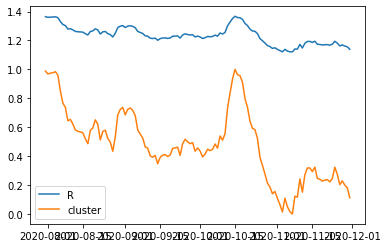

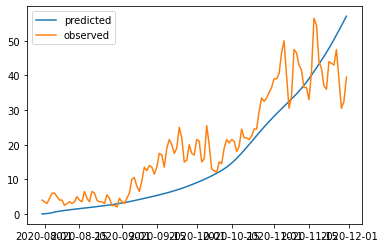

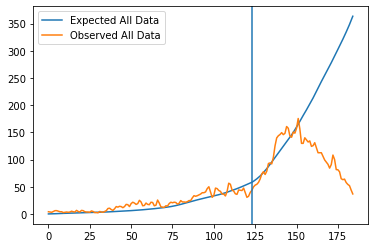

Step: 250, Learning Rate: 0.00777924670742873 Time: 0.0326, Training Comparison Loss: 1417.18359375, Test Comparison Loss: 13727.5712890625, Phi: 24.776771545410156 


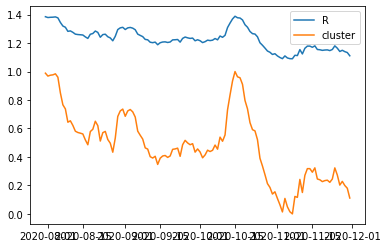

Step: 300, Learning Rate: 0.007399663251239432 Time: 0.0337, Training Comparison Loss: 1229.7828369140625, Test Comparison Loss: 10239.236328125, Phi: 24.770906448364258 


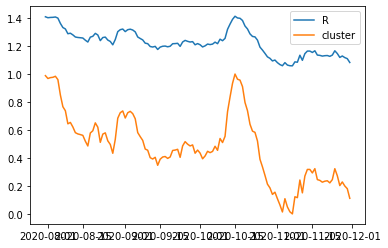

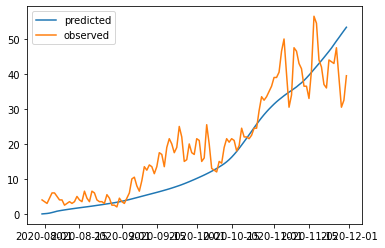

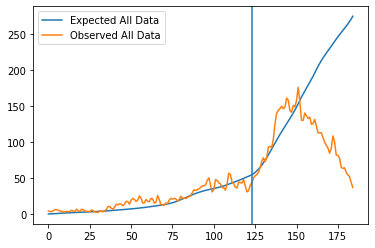

Step: 350, Learning Rate: 0.007038601331341688 Time: 0.0294, Training Comparison Loss: 921.4909057617188, Test Comparison Loss: 5218.0654296875, Phi: 24.76567268371582 


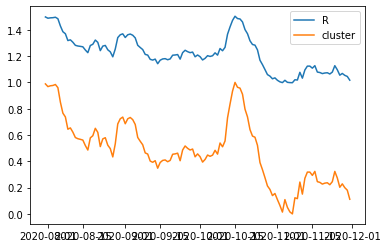

Step: 400, Learning Rate: 0.006695157201007331 Time: 0.0346, Training Comparison Loss: 792.8915405273438, Test Comparison Loss: 2141.966796875, Phi: 24.761608123779297 


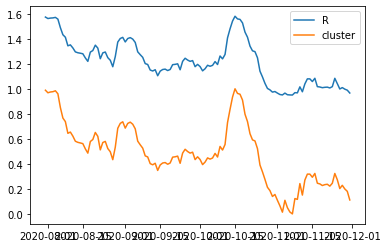

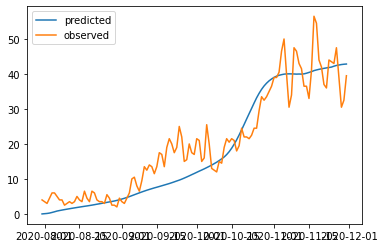

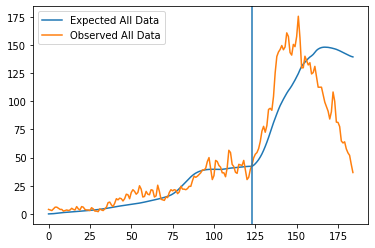

Step: 450, Learning Rate: 0.006368471211262053 Time: 0.0334, Training Comparison Loss: 783.3056030273438, Test Comparison Loss: 1865.7181396484375, Phi: 24.75780487060547 


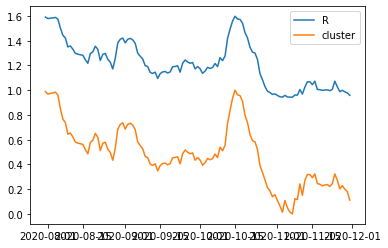

Step: 500, Learning Rate: 0.006057725659163231 Time: 0.0332, Training Comparison Loss: 778.6702270507812, Test Comparison Loss: 1829.6812744140625, Phi: 24.753971099853516 


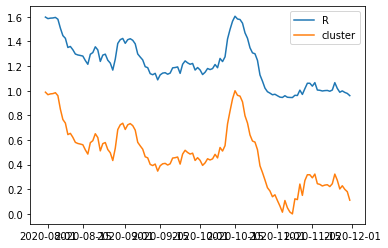

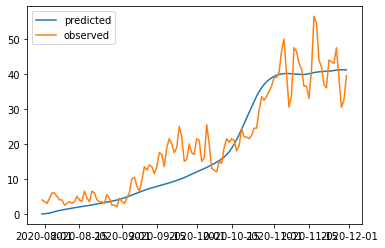

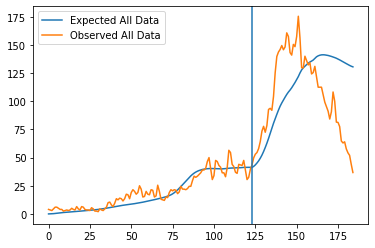

Step: 550, Learning Rate: 0.0057621427410696376 Time: 0.032, Training Comparison Loss: 774.1906127929688, Test Comparison Loss: 1800.818603515625, Phi: 24.75010871887207 


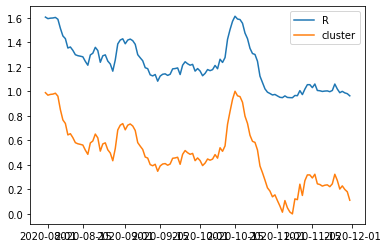

Step: 600, Learning Rate: 0.005480982605780108 Time: 0.0315, Training Comparison Loss: 769.7879028320312, Test Comparison Loss: 1796.4736328125, Phi: 24.746232986450195 


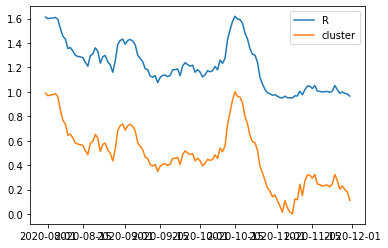

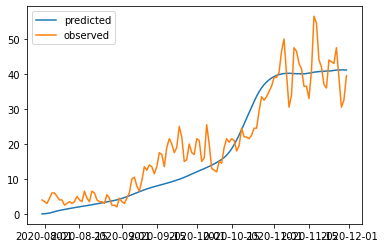

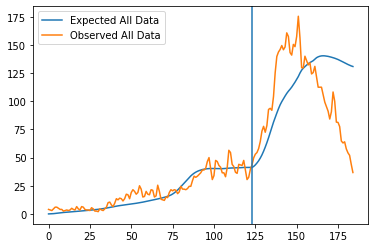

Step: 650, Learning Rate: 0.005213541502668067 Time: 0.0331, Training Comparison Loss: 765.5744018554688, Test Comparison Loss: 1772.1839599609375, Phi: 24.742359161376953 


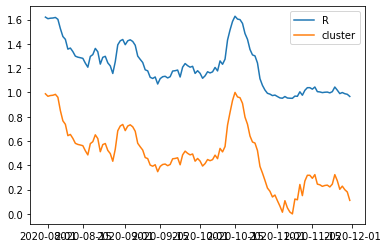

Step: 700, Learning Rate: 0.004959150020176671 Time: 0.0328, Training Comparison Loss: 761.5718994140625, Test Comparison Loss: 1768.117919921875, Phi: 24.738494873046875 


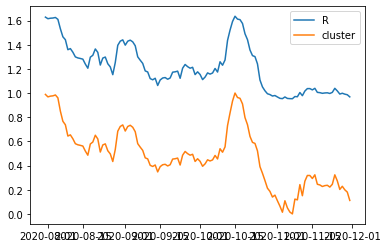

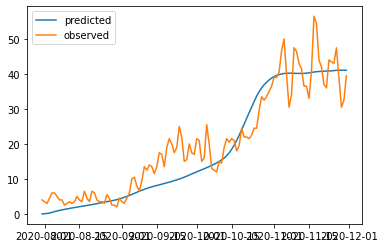

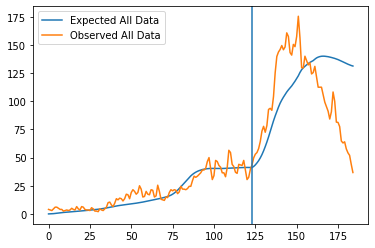

Step: 750, Learning Rate: 0.004717171410265472 Time: 0.0306, Training Comparison Loss: 758.2064208984375, Test Comparison Loss: 1740.9329833984375, Phi: 24.734655380249023 


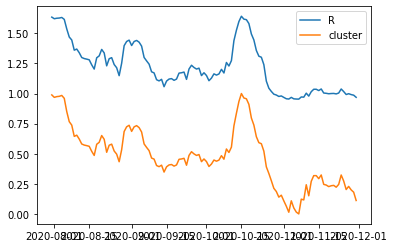

Step: 800, Learning Rate: 0.004486999994614646 Time: 0.0319, Training Comparison Loss: 754.9784545898438, Test Comparison Loss: 1738.0860595703125, Phi: 24.7308406829834 


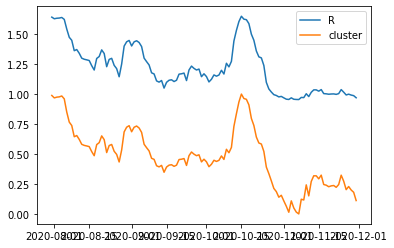

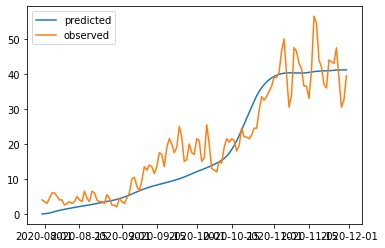

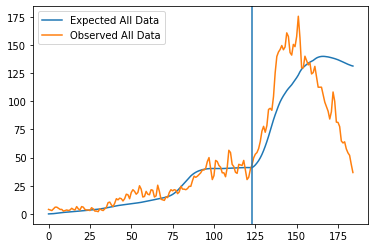

Step: 850, Learning Rate: 0.004268059648597501 Time: 0.0338, Training Comparison Loss: 751.6575317382812, Test Comparison Loss: 1736.9295654296875, Phi: 24.72705841064453 


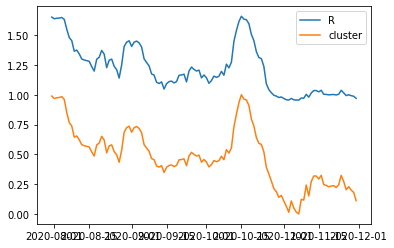

Step: 900, Learning Rate: 0.0040598023592265855 Time: 0.0333, Training Comparison Loss: 748.5955200195312, Test Comparison Loss: 1756.50830078125, Phi: 24.723318099975586 


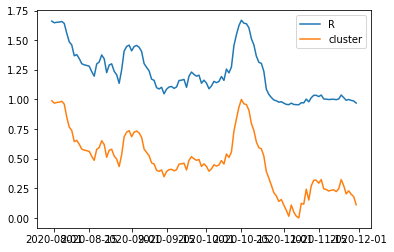

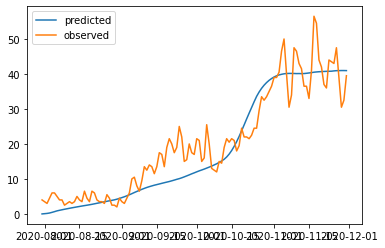

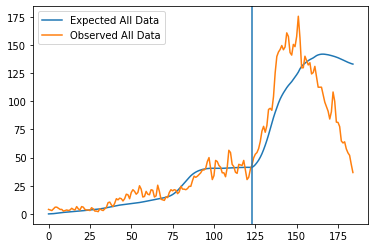

Step: 950, Learning Rate: 0.0038617068534639145 Time: 0.0328, Training Comparison Loss: 745.0615234375, Test Comparison Loss: 1734.801025390625, Phi: 24.719623565673828 


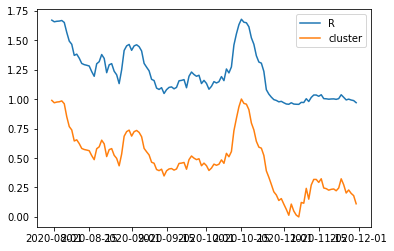

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR

epochs = 1000
# model_parameter = [dict_param['prime_values']['alpha'], dict_param['prime_values']['phi']] + [dict_param['prime_values']['epsilon']]

params_to_be_optimized = method.get_parameters() + [dict_param['prime_values']['phi']]
if observation == 'hospitalization':
  params_to_be_optimized = params_to_be_optimized + [dict_param['prime_values']['alpha']]

optimizer = optim.Adam(params_to_be_optimized, lr=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.999)

for i in range(epochs):
  iteration_time = time.time()
  optimizer.zero_grad()

  # transform alphi, phi
  dict_param = transform_prime_variables(dict_param)

  # forward pass
  expected = epid_model(R=method.calculate_R(method.cluster_percentage_train), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation][:df_obs_train.shape[0]]
  
  # calc loss
  comparison_loss_train =  calc_mse(expected, observed_train) * dict_param['real_values']['phi']
  method_loss = method.calculate_loss()
  model_param_loss = calc_prior_loss(dict_param, device, dtype)
  loss = comparison_loss_train + method_loss + model_param_loss

  # backward pass
  loss.backward()
  optimizer.step()
  scheduler.step()
  
  
  with torch.no_grad():
    if i % 50==0:
        current_time = round((time.time() - iteration_time),4)
        current_lr = optimizer.state_dict()['param_groups'][0]['lr']
        expected_test = epid_model(R=method.calculate_R(cluster_percentage_train_test), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation][-df_obs_test.shape[0]:]
        print(f"Step: {i}, Learning Rate: {current_lr} Time: {current_time}, Training Comparison Loss: {comparison_loss_train}, Test Comparison Loss: {calc_mse(expected_test, observed_test)}, Phi: {dict_param['real_values']['phi']} ")
        plt.plot(df_obs_train['Date'], method.calculate_R(method.cluster_percentage_train).cpu().detach().numpy(), label='R')
        plt.plot(df_obs_train['Date'], method.cluster_percentage_train, label='cluster')
        plt.legend()
        plt.show()
    if i % 100==0:
      plt.plot(df_obs_train['Date'], expected.cpu().detach().numpy(), label='predicted')
      plt.plot(df_obs_train['Date'], observed_train.cpu().detach().numpy(), label='observed')
      plt.legend()
      plt.show()

      expected_train_test = epid_model(R=method.calculate_R(cluster_percentage_train_test), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]
      plt.plot(expected_train_test.cpu().detach().numpy(),label='Expected All Data')
      plt.plot(observed_train_test.cpu().detach().numpy(),label='Observed All Data')
      plt.axvline(x=observed_train.shape[0])
      plt.legend()
      plt.show()


# Evaluation

## Train and Test Time 

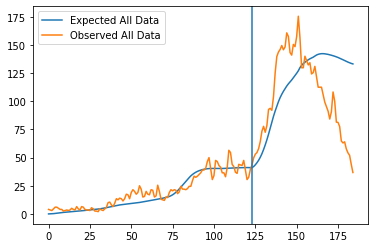

In [ ]:
expected_train_test = epid_model(R=method.calculate_R(cluster_percentage_train_test), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]
plt.plot(expected_train_test.cpu().detach().numpy(),label='Expected All Data')
plt.plot(observed_train_test.cpu().detach().numpy(),label='Observed All Data')
plt.axvline(x=observed_train.shape[0])
plt.legend()
plt.show()

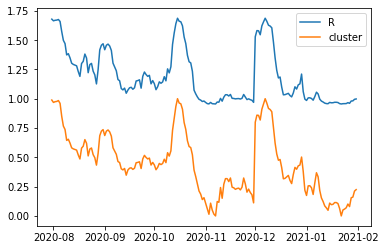

In [ ]:
# Plot R-Value & Cluster Percentage
plt.plot(df_obs['Date'], method.calculate_R(cluster_percentage_train_test).cpu().detach().numpy(), label='R')
plt.plot(df_obs['Date'], cluster_percentage_train_test, label='cluster')
plt.legend()
plt.show()

## Eval on Test Data


Comparison Loss Train: 741.8770751953125 - Comparison Loss Test: 43018.671875


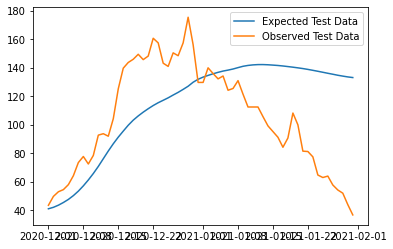

In [ ]:
expected_test = expected_train_test[-df_obs_test.shape[0]:]
comparison_loss_test = calc_mse(expected_test, observed_test) * dict_param['real_values']['phi']
print(f'Comparison Loss Train: {comparison_loss_train} - Comparison Loss Test: {comparison_loss_test}')

plt.plot(df_obs_test['Date'], expected_test.cpu().detach().numpy(),label='Expected Test Data')
plt.plot(df_obs_test['Date'], observed_test.cpu().detach().numpy(),label='Observed Test Data')
plt.legend()
plt.show()

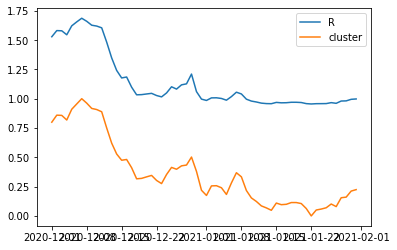

In [ ]:
# Plot R-Value & Cluster Percentage
plt.plot(df_obs_test['Date'], method.calculate_R(method.cluster_percentage_test).cpu().detach().numpy(), label='R')
plt.plot(df_obs_test['Date'], method.cluster_percentage_test, label='cluster')
plt.legend()
plt.show()

## Eval What IF

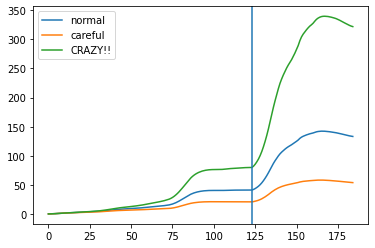

In [ ]:
expected_normal = epid_model(R=method.calculate_R(cluster_percentage_train_test), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]
expected_careful= epid_model(R=method.calculate_R(cluster_percentage_train_test*0.9), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]
expected_crazy = epid_model(R=method.calculate_R(cluster_percentage_train_test*1.1), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]

plt.plot(expected_normal.cpu().detach().numpy(),label='normal')
plt.plot(expected_careful.cpu().detach().numpy(),label='careful')
plt.plot(expected_crazy.cpu().detach().numpy(),label='CRAZY!!')
plt.axvline(x=observed_train.shape[0])
plt.legend()
plt.show()

## Eval Cluster Percentage vs R-Value

Slope: 0.8366621711883151, intercept: 0.8313878189010817, r-squared: 0.962924366307446


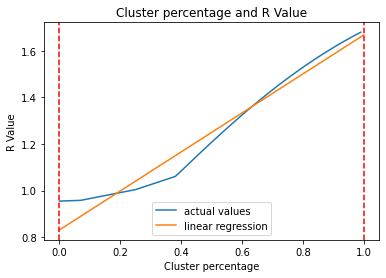

In [ ]:
from scipy import stats

x = np.arange(0,1 , 0.01)
y = np.squeeze(method.calculate_R(x).cpu().detach().numpy())


x_min = cluster_percentage_train_test.min()
x_max = cluster_percentage_train_test.max()
x_bound = np.arange(x_min, x_max + 0.01 , 0.01)
y_bound = np.squeeze(method.calculate_R(x_bound).cpu().detach().numpy())

slope, intercept, r_value, p_value, std_err = stats.linregress(x_bound, y_bound)
y_linreg = intercept + slope * x_bound
print(f'Slope: {slope}, intercept: {intercept}, r-squared: {r_value**2}')
plt.plot(x, y, label='actual values')
plt.plot(x_bound, y_linreg, label='linear regression')
plt.axvline(x=x_min, c='r', linestyle='--')
plt.axvline(x=x_max, c='r', linestyle='--')
plt.xlabel('Cluster percentage')
plt.ylabel('R Value')
plt.title('Cluster percentage and R Value')
plt.legend()
plt.show()

Eval Newly Infected

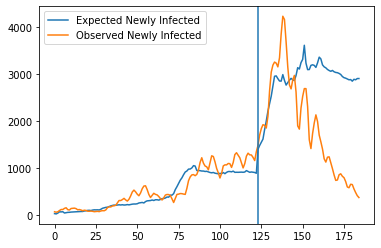

In [ ]:
expected_newly = epid_model(R=method.calculate_R(cluster_percentage_train_test), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)['newly_infected']

plt.plot(expected_newly.cpu().detach().numpy(),label='Expected Newly Infected')
plt.plot(df_obs['newly_infected'],label='Observed Newly Infected')
plt.axvline(x=observed_train.shape[0])
plt.legend()
plt.show()